# Seoul Bike Sharing Demand Regression Analysis

**Student name:** Rebecca Chu

## Overview

## Business Problem

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import statistics as stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

from datetime import time
from itertools import combinations

## Data Understanding

### Seoul Bike Sharing System Rentals

The dataset being explored contains the number of public bicycles rented per hour in the Seoul Public Bike (Ttareungyi) rental system and can be found here https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand. It contains 8,760 hours of data, including corresponding weather information and whether the day rented was a holiday.

Seoul Bike Sharing Demand. (2020). UCI Machine Learning Repository. https://doi.org/10.24432/C5F62R.

In [2]:
sb = pd.read_csv('./data/SeoulBikeData.csv', encoding='latin-1')
sb.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


## Data Preparation

### 1. Data Cleaning

#### 1.1. Renaming Columns and Converting Datatypes

For readability and ease of writing code, I renamed the columns. I also converted `Date` into a datetime type so that I could extract the month the bikes were rented.

In [3]:
# transforming column names to all lowercase characters 
sb.columns = map(str.lower, sb.columns)

# renaming appropriate columns for readability
sb.rename(
    columns={
        'rented bike count': 'bike_count', 
        'temperature(°c)': 'temp', 
        'humidity(%)': 'humidity', 
        'wind speed (m/s)': 'wind_speed_ms', 
        'visibility (10m)': 'visibility_10m',
        'dew point temperature(°c)': 'dew_point_temp',
        'solar radiation (mj/m2)': 'solar_rad',
        'rainfall(mm)': 'rainfall_mm',
        'snowfall (cm)': 'snowfall_cm',
        'functioning day': 'functioning_day',
    }, 
    inplace=True)

In [4]:
sb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             8760 non-null   object 
 1   bike_count       8760 non-null   int64  
 2   hour             8760 non-null   int64  
 3   temp             8760 non-null   float64
 4   humidity         8760 non-null   int64  
 5   wind_speed_ms    8760 non-null   float64
 6   visibility_10m   8760 non-null   int64  
 7   dew_point_temp   8760 non-null   float64
 8   solar_rad        8760 non-null   float64
 9   rainfall_mm      8760 non-null   float64
 10  snowfall_cm      8760 non-null   float64
 11  seasons          8760 non-null   object 
 12  holiday          8760 non-null   object 
 13  functioning_day  8760 non-null   object 
dtypes: float64(6), int64(4), object(4)
memory usage: 958.2+ KB


In [5]:
# converting date to datetime datatype
sb.date = pd.to_datetime(sb.date, format='%d/%m/%Y')

# descriptive statistics for date Series
sb.date.describe()

count                             8760
mean     2018-05-31 23:59:59.999999744
min                2017-12-01 00:00:00
25%                2018-03-02 00:00:00
50%                2018-06-01 00:00:00
75%                2018-08-31 00:00:00
max                2018-11-30 00:00:00
Name: date, dtype: object

#### 1.2. Dropping Irrelevant Rows

Taking a look at `functioning_day` we can see that the dataframe includes 295 rows where the rental system was not functioning, which corresponds with the number of rows where `bike_count` was 0.

I decided to drop rows where the rental system was not functioning to avoid skewing the model.

In [6]:
sb.functioning_day.value_counts()

functioning_day
Yes    8465
No      295
Name: count, dtype: int64

In [7]:
sb.bike_count.value_counts()

bike_count
0       295
122      19
223      19
262      19
165      18
       ... 
2096      1
2440      1
1600      1
3384      1
595       1
Name: count, Length: 2166, dtype: int64

In [8]:
# creating new dataframe with Functioning Days
sb = sb[sb.functioning_day == 'Yes']

#### 1.3. Creating New Features

In [9]:
# creating a new column for month sold
sb['month'] = sb.date.dt.month

# creating a new column for month sold
sb['day_of_week'] = sb.date.dt.day_name()

I also wanted to explore whether daylight had an impact on the number of bikes rented. Using the Astral package, I created a csv of the dawn and dusk times in Seoul between 01-12-2017 and 30-11-2018, which can be found in notebook `dawn-dusk-times.ipynb`. I chose dawn and dusk times over sunrise and sunset so that I could measure from first light to last light. 

In [10]:
sun_info = pd.read_csv('./data/Sun_Info.csv')
sun_info.head()

,Unnamed: 0,dawn,dusk,date
0,0,06:58:41.124894,17:43:18.063001,2017-12-01
1,1,06:59:34.840849,17:43:10.603905,2017-12-02
2,2,07:00:27.808583,17:43:05.125579,2017-12-03
3,3,07:01:19.981740,17:43:01.627122,2017-12-04
4,4,07:02:11.313759,17:43:00.106002,2017-12-05


In [11]:
# dropping the irrelevant column
sun_info.drop('Unnamed: 0', axis=1, inplace=True)

In [12]:
sun_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   dawn    365 non-null    object
 1   dusk    365 non-null    object
 2   date    365 non-null    object
dtypes: object(3)
memory usage: 8.7+ KB


In [13]:
# converting date column to a datatime datatype so that I can merge sun_info to sb
sun_info.date = pd.to_datetime(sun_info.date)

In [14]:
# merging sun_info to sb
sb = sb.merge(sun_info, on='date', how='left')

So that I can calculate whether `hour` sits within the daylight times between dawn and dusk, I converted `dawn` and `dusk` into floats.

In [15]:
# replacing : with . so that I can convert each value into a float
sb.dawn = sb.dawn.map(lambda x: x.replace(':','.')[:5])
sb.dusk = sb.dusk.map(lambda x: x.replace(':','.')[:5])

# converting dawn and dusk into float datatypes
sb.dawn = sb.dawn.astype(float)
sb.dusk = sb.dusk.astype(float)

In [16]:
daylight = []

# creating a list of whether each hour sits within daylight (1) or not (0)
for i, v in enumerate(sb.bike_count):
    if sb.dawn[i] < sb.hour[i] < sb.dusk[i]:
        daylight.append(1)
    else:
        daylight.append(0)

sb['daylight'] = daylight

I also decided to change `holiday` into a numerical binary, where 1 = Holiday and 0 = No Holiday. 

In [17]:
# replacing No Holiday with 0
sb.holiday.replace('No Holiday', 0, inplace=True)
# replacing Holiday with 1
sb.holiday.replace('Holiday', 1, inplace=True)

Finally, I dropped irrelevant columns.

In [18]:
# dropping irrelevant columns
sb.drop(['functioning_day', 'dawn', 'dusk'], axis=1, inplace=True)

The final dataset includes the following variables:

* Date
* Rented Bike Count
* Hour
* Temperature (°C)
* Humidity (%)
* Wind Speed (m/s)
* Visibility (10m)
* Dew Point Temperature (°C)
* Solar Radiation (MJ/m2)
* Rainfall (mm)
* Snowfall (cm)
* Season
* Holiday (0 = No Holiday, 1 = Holiday)
* Month
* Day of the Week
* Daylight (0 = No Daylight, 1 = Daylight)

In [19]:
sb.head()

,date,bike_count,hour,temp,humidity,wind_speed_ms,visibility_10m,dew_point_temp,solar_rad,rainfall_mm,snowfall_cm,seasons,holiday,month,day_of_week,daylight
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,0,12,Friday,0
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,0,12,Friday,0
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,0,12,Friday,0
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,0,12,Friday,0
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,0,12,Friday,0


To get a sense of the data I was working with, I grouped ... Below we can see that even within the year, bike rentals tended to increase. There are a few possibilities external to the variables we have that may explain this behaviour; e-bike rentals may have increased in popularity leading, the rental company may have increased the number of its bikes allowing more bikes to be rented. As we can not factor these possibilities into this analysis, I will be focusing on inference rather than prediction.

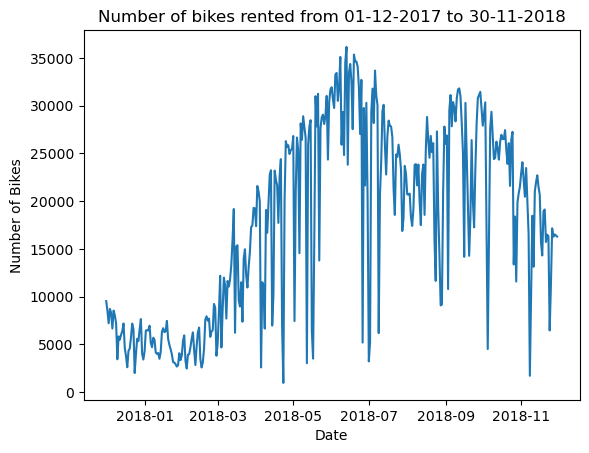

In [20]:
groupedby_date = sb.groupby(['date']).sum().reset_index()

fig, ax = plt.subplots()
ax.plot(groupedby_date['date'], groupedby_date['bike_count'])
ax.set_title('Number of bikes rented from 01-12-2017 to 30-11-2018')

plt.xlabel('Date')
plt.ylabel('Number of Bikes');

#### 1.4. Train Test Split

While the primary goal of this analysis is inference, I decided to split the data into train and test to ensure that the predictors that appeared significant in my model would also be statistically significant for other observations; we want to ensure that these findings are applicable to the future as that is when the advertisements will be aired. I chose to use an 80/20 split.

In [21]:
X = sb.drop('bike_count', axis=1)
y = sb['bike_count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

In [22]:
X_train.describe().apply(lambda x: x.apply('{0:.2f}'.format))

,date,hour,temp,humidity,wind_speed_ms,visibility_10m,dew_point_temp,solar_rad,rainfall_mm,snowfall_cm,holiday,month,daylight
count,6772.00,6772.00,6772.00,6772.00,6772.00,6772.00,6772.00,6772.00,6772.00,6772.00,6772.00,6772.00,6772.00
mean,.2f,11.49,12.78,58.16,1.74,1425.88,3.95,0.58,0.15,0.08,0.05,6.44,0.55
min,.2f,0.00,-17.50,0.00,0.00,27.00,-30.60,0.00,0.00,0.00,0.00,1.00,0.00
25%,.2f,6.00,3.10,42.00,1.00,920.75,-5.20,0.00,0.00,0.00,0.00,3.00,0.00
50%,.2f,12.00,13.45,57.00,1.50,1669.00,4.70,0.02,0.00,0.00,0.00,6.00,1.00
75%,.2f,17.00,22.70,74.00,2.30,1999.00,15.20,0.95,0.00,0.00,0.00,9.00,1.00
max,.2f,23.00,39.40,98.00,7.40,2000.00,27.20,3.52,35.00,8.80,1.00,12.00,1.00
std,nan,6.89,12.11,20.59,1.04,611.38,13.25,0.88,1.10,0.45,0.22,3.45,0.50


### 2. Exploring the Training Data

#### 2.1. Looking at the Distribution of Variables

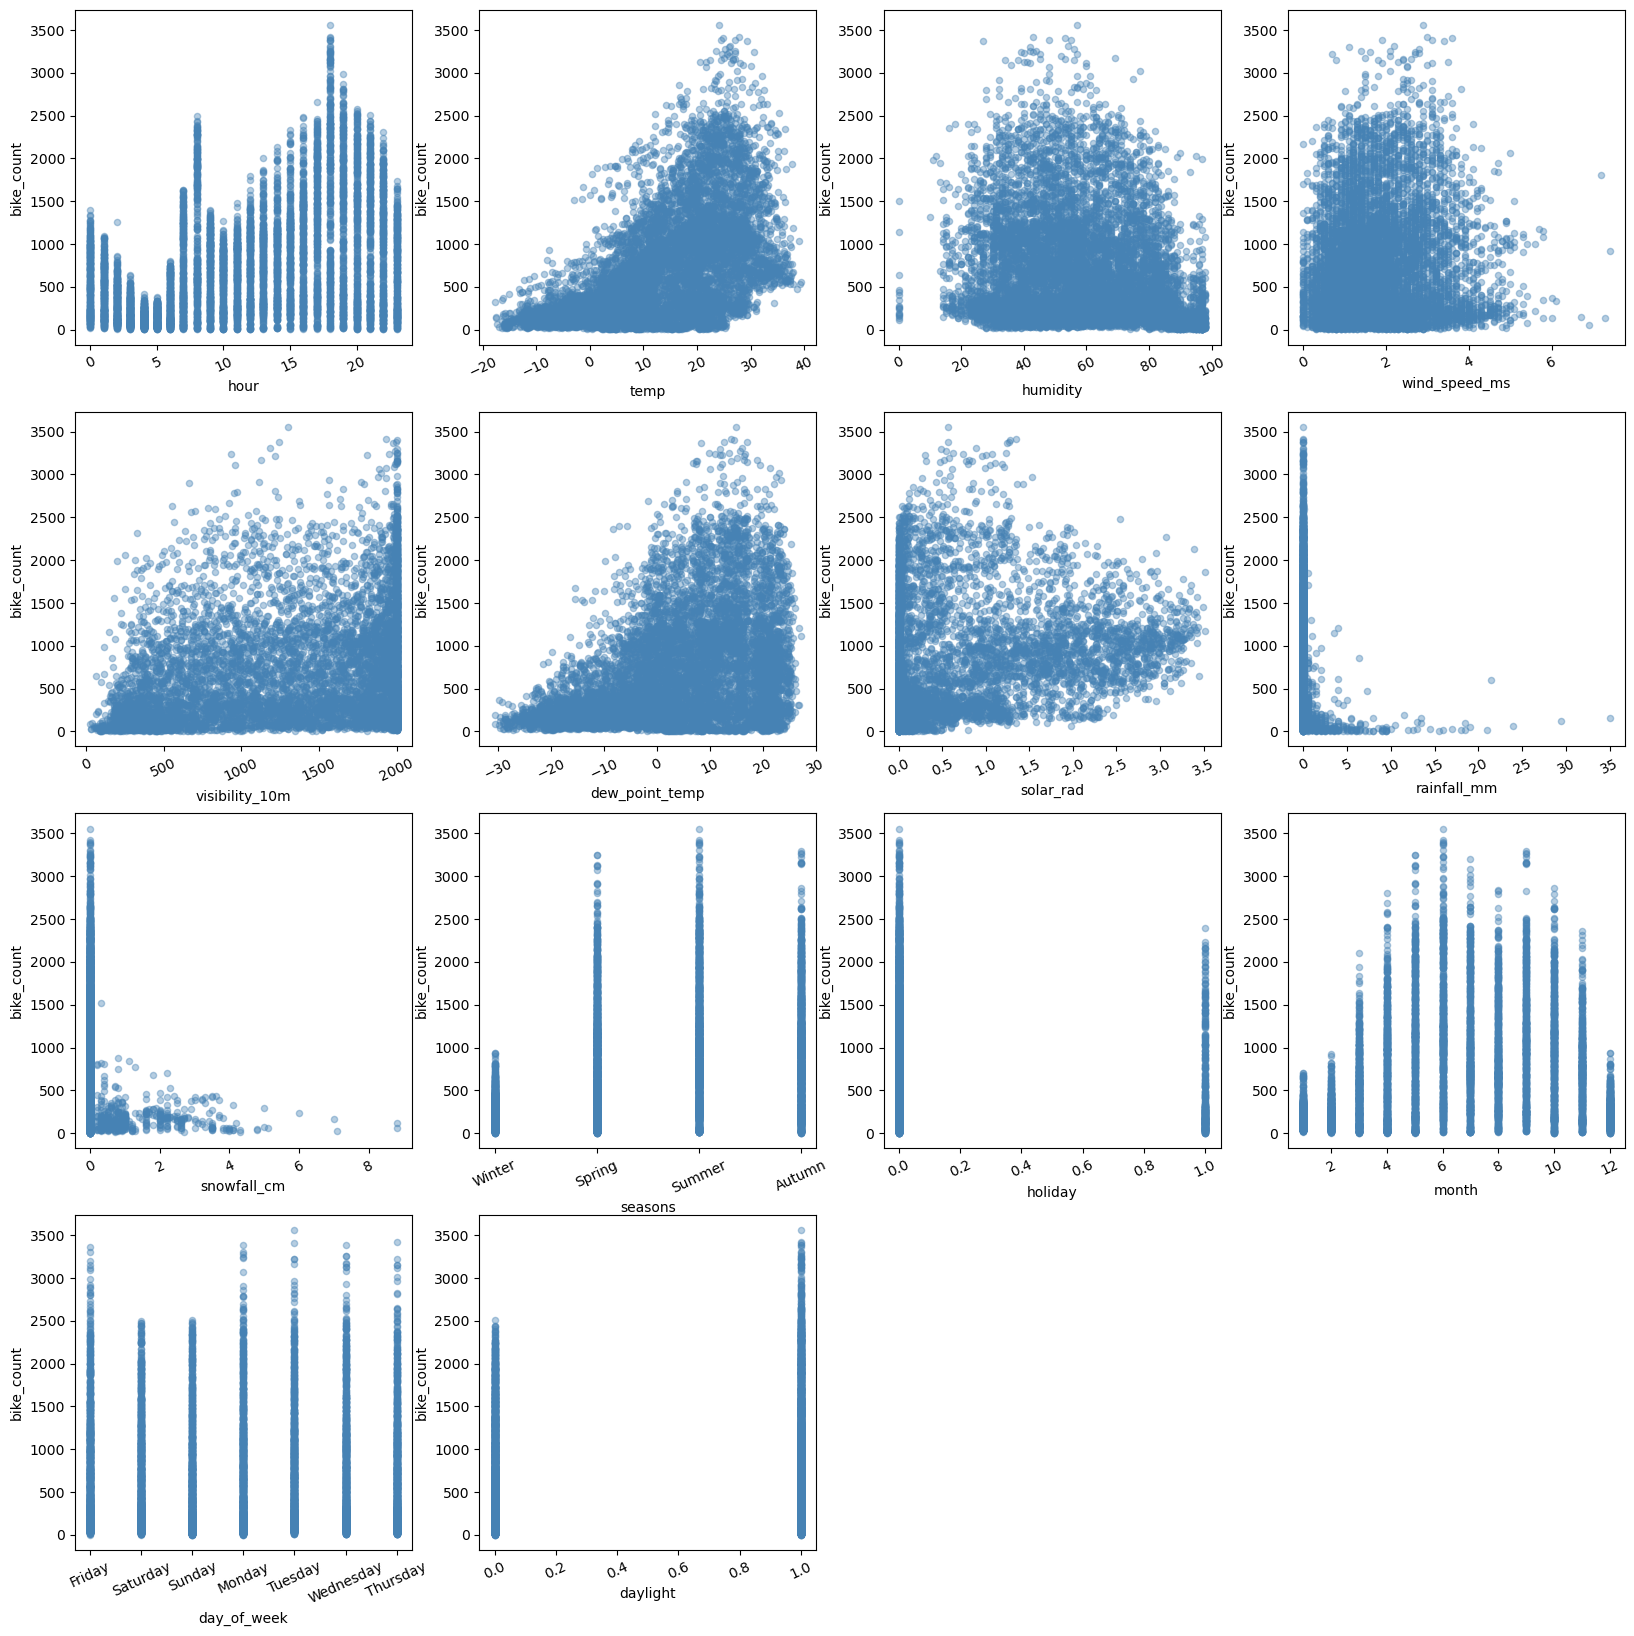

In [23]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20,20))

# delete empty subplots
for i in range(2,4):
    fig.delaxes(axes[3,i])

predictors = ['hour', 'temp', 'humidity', 'wind_speed_ms', 'visibility_10m', 'dew_point_temp', 
              'solar_rad', 'rainfall_mm', 'snowfall_cm', 'seasons', 'holiday', 'month', 'day_of_week', 'daylight']

for xcol, ax in zip(predictors, axes.flatten()): 
    sb.plot(kind='scatter', x=xcol, y='bike_count', ax=ax, rot=25, alpha=0.4, color='steelblue');

#### 2.2. Account for Multicollinearity

In [24]:
numerical_data = ['hour', 'temp', 'humidity', 'wind_speed_ms', 'visibility_10m', 'dew_point_temp', 'solar_rad', 
                  'rainfall_mm', 'snowfall_cm', 'holiday', 'month', 'daylight']


X_train[numerical_data].corr()

,hour,temp,humidity,wind_speed_ms,visibility_10m,dew_point_temp,solar_rad,rainfall_mm,snowfall_cm,holiday,month,daylight
hour,1.000000,0.128641,-0.238627,0.292045,0.109612,0.007962,0.150491,0.007564,-0.026597,0.004718,0.003049,0.168776
temp,0.128641,1.000000,0.165073,-0.043967,0.023694,0.913370,0.356843,0.052144,-0.216349,-0.059938,0.214861,0.256231
humidity,-0.238627,0.165073,1.000000,-0.336094,-0.553389,0.540461,-0.463676,0.244102,0.111642,-0.046124,0.138070,-0.240877
wind_speed_ms,0.292045,-0.043967,-0.336094,1.000000,0.182905,-0.181941,0.326663,-0.018746,0.000390,0.034410,-0.160019,0.241448
visibility_10m,0.109612,0.023694,-0.553389,0.182905,1.000000,-0.189854,0.162852,-0.182665,-0.129993,0.029621,0.059907,0.031634
dew_point_temp,0.007962,0.913370,0.540461,-0.181941,-0.189854,1.000000,0.096517,0.129696,-0.147828,-0.069451,0.239759,0.107040
solar_rad,0.150491,0.356843,-0.463676,0.326663,0.162852,0.096517,1.000000,-0.078697,-0.073852,-0.007763,-0.032262,0.596098
rainfall_mm,0.007564,0.052144,0.244102,-0.018746,-0.182665,0.129696,-0.078697,1.000000,0.011176,-0.010901,0.008423,0.028136
snowfall_cm,-0.026597,-0.216349,0.111642,0.000390,-0.129993,-0.147828,-0.073852,0.011176,1.000000,-0.011306,0.061137,-0.017719
holiday,0.004718,-0.059938,-0.046124,0.034410,0.029621,-0.069451,-0.007763,-0.010901,-0.011306,1.000000,0.037509,-0.017675


In [25]:
# saving absolute value of the correlation matrix as a data frame
df = X_train[numerical_data].corr().abs().stack().reset_index().sort_values(0, ascending=False)

df['pairs'] = list(zip(df.level_0, df.level_1))
df.drop(columns=['level_1','level_0'], inplace=True)
df.set_index(['pairs'], inplace=True)
df.columns = ['cc']

In [26]:
df[(df.cc >.75) & (df.cc<1)]

,cc
pairs,
"(dew_point_temp, temp)",0.91337
"(temp, dew_point_temp)",0.91337


I decided to drop `dew_point_temp` as we use `temperature` as a reference and may influence people's future decisions whether to rent a bike or not ... 
I also dropped date as I would not be using it for my models.

In [27]:
# dropping dew_point_temp and date
X_train.drop(['dew_point_temp', 'date'], axis=1, inplace=True)

## Data Modeling 

### 1. Preparing for Model 1

#### 1.1. Creating Dummy Variables

In [28]:
def create_dummy(cat, df):
    '''
    Function takes a categorical Series and a dataframe and returns dummy variables using get_dummies(). 
    Note that no columns are dropped.
    '''
    return pd.get_dummies(df[f'{cat}'], prefix=f'{cat}', dtype=float)

For hours, I decided to drop 5am, which appears to see the lowest number of bikes rented per hour.

In [29]:
# creating dummy variables
hour_dummies = create_dummy('hour', X_train)
seasons_dummies = create_dummy('seasons', X_train)
holiday_dummies = create_dummy('holiday', X_train)
month_dummies = create_dummy('month', X_train)
day_dummies = create_dummy('day_of_week', X_train)
daylight_dummies = create_dummy('daylight', X_train)

# removing original columns from dataset
X_train_m1 = X_train.drop(['hour', 'seasons', 'holiday', 'month', 'day_of_week', 'daylight'], 
                                    axis=1)

# concating dummy columns into dataset
X_train_m1 = pd.concat([X_train_m1, hour_dummies, seasons_dummies, holiday_dummies, month_dummies, day_dummies, daylight_dummies], 
                       axis=1)

# removing dropping one column for each categorical
X_train_m1.drop(['hour_5', 'seasons_Winter', 'holiday_1', 'month_1', 'day_of_week_Monday', 'daylight_0', ], axis=1,
                          inplace=True)

X_train_m1.head()

,temp,humidity,wind_speed_ms,visibility_10m,solar_rad,rainfall_mm,snowfall_cm,hour_0,hour_1,hour_2,...,month_10,month_11,month_12,day_of_week_Friday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,daylight_1
2241,8.8,97,1.3,196,0.20,0.2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
7149,20.1,54,1.2,2000,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5177,26.6,52,2.2,2000,1.02,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3368,14.6,54,0.9,431,0.89,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1459,-1.7,91,1.1,167,0.00,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


                            OLS Regression Results                            
Dep. Variable:             bike_count   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     331.2
Date:                Fri, 06 Oct 2023   Prob (F-statistic):               0.00
Time:                        21:15:28   Log-Likelihood:                -49216.
No. Observations:                6772   AIC:                         9.853e+04
Df Residuals:                    6722   BIC:                         9.887e+04
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -56.44

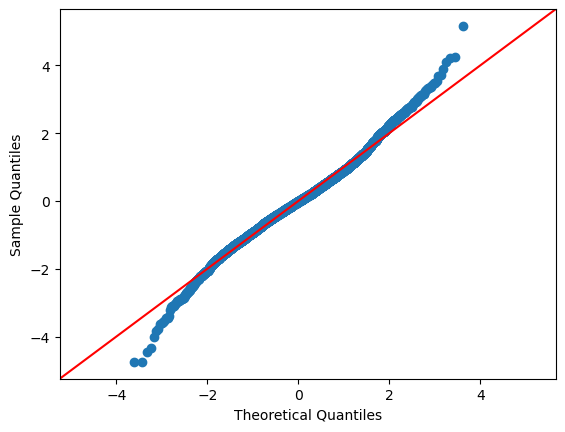

In [30]:
X = X_train_m1
y = y_train

# building the model
X_int = sm.add_constant(X)
model = sm.OLS(y, X_int).fit()
print(model.summary())

# checking normality assumptions
sm.qqplot(model.resid, line='45', fit=True);

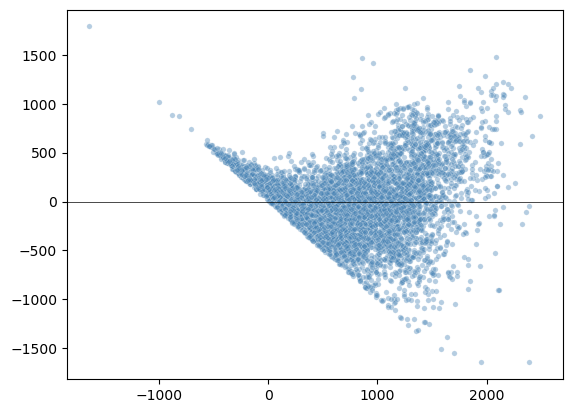

In [31]:
# checking homoscedasticity assumption
pred = model.predict(X_int)
residuals = model.resid

sns.scatterplot(x=pred, y=residuals, s=15, alpha=0.4, color='steelblue')
plt.axhline(y=0, color='black', linewidth=0.5);

### Model 1 Observations

Looking at the model, snowfall appears to have a positive linear relationship with bike rentals, which goes against 

We can see that for rainfall and snowfall, the majority of the distribution lies on 0, with any 

So that these 'outliers' do not skew my model, I decided to treat them as categoricals 

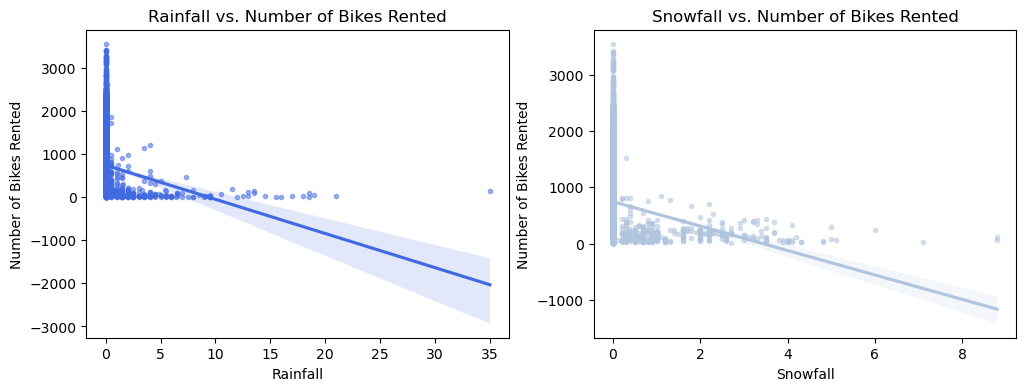

In [32]:
fig, axes = plt.subplots(1,2,figsize=(12,4))
sns.regplot(x=X_train.rainfall_mm, y=y_train, color='royalblue', scatter_kws={'alpha':0.5, 's':9}, ax=axes[0]
           ).set(title='Rainfall vs. Number of Bikes Rented')
sns.regplot(x=X_train.snowfall_cm, y=y_train, color='lightsteelblue', scatter_kws={'alpha':0.5, 's':9}, ax=axes[1]
           ).set(title='Snowfall vs. Number of Bikes Rented')
axes[0].set_xlabel('Rainfall')
axes[1].set_xlabel('Snowfall')
axes[0].set_ylabel('Number of Bikes Rented')
axes[1].set_ylabel('Number of Bikes Rented');

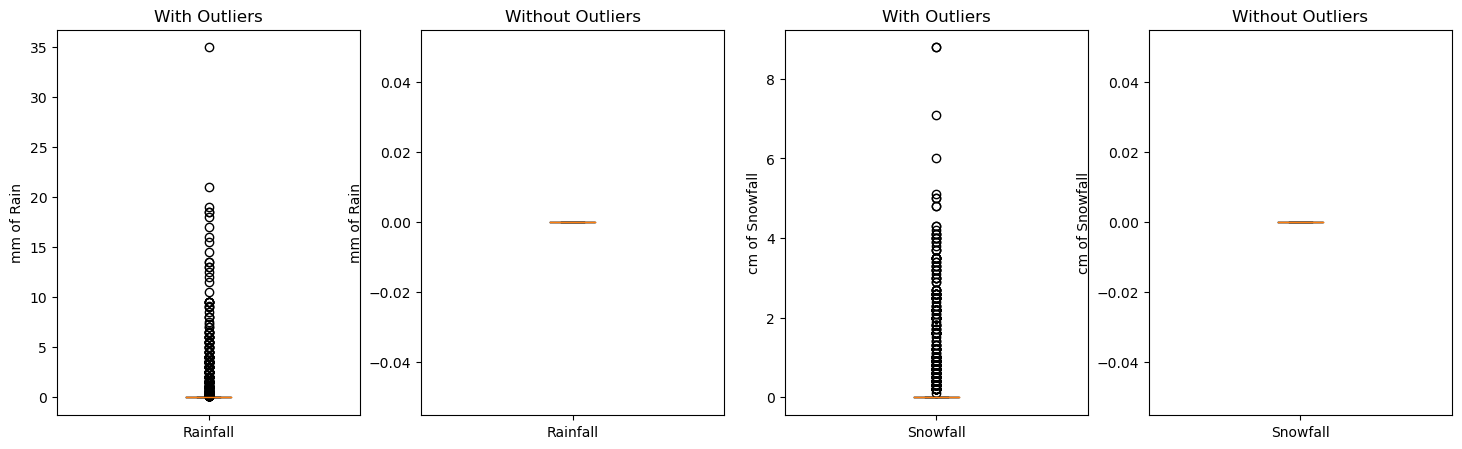

In [33]:
# generating boxplots for rainfall with and without outliers 
fig, axes = plt.subplots(1, 4, figsize=(18,5))

axes[0].boxplot(X_train.rainfall_mm)
axes[1].boxplot(X_train.rainfall_mm, showfliers=False)
axes[2].boxplot(X_train.snowfall_cm)
axes[3].boxplot(X_train.snowfall_cm, showfliers=False)

axes[0].title.set_text('With Outliers')
axes[1].title.set_text('Without Outliers')
axes[0].set_xlabel("Rainfall")
axes[1].set_xlabel("Rainfall")
axes[0].set_ylabel("mm of Rain")
axes[1].set_ylabel("mm of Rain")
axes[0].xaxis.set_tick_params(labelbottom=False)
axes[1].xaxis.set_tick_params(labelbottom=False)

axes[2].title.set_text('With Outliers')
axes[3].title.set_text('Without Outliers')
axes[2].set_xlabel("Snowfall")
axes[3].set_xlabel("Snowfall")
axes[2].set_ylabel("cm of Snowfall")
axes[3].set_ylabel("cm of Snowfall")
axes[2].xaxis.set_tick_params(labelbottom=False)
axes[3].xaxis.set_tick_params(labelbottom=False);

### 2. Preparing for Model 2 

In [34]:
X_train.head()

,hour,temp,humidity,wind_speed_ms,visibility_10m,solar_rad,rainfall_mm,snowfall_cm,seasons,holiday,month,day_of_week,daylight
2241,9,8.8,97,1.3,196,0.20,0.2,0.0,Spring,0,3,Sunday,1
7149,21,20.1,54,1.2,2000,0.00,0.0,0.0,Autumn,0,9,Saturday,0
5177,17,26.6,52,2.2,2000,1.02,0.0,0.0,Summer,0,7,Friday,1
3368,8,14.6,54,0.9,431,0.89,0.0,0.0,Spring,0,4,Saturday,1
1459,19,-1.7,91,1.1,167,0.00,0.0,3.0,Winter,0,1,Tuesday,0


In [35]:
X_train.day_of_week.replace(dict.fromkeys(['Monday','Tuesday','Wednesday','Thursday', 'Friday'], 'weekday'), inplace=True)
X_train.day_of_week.replace(dict.fromkeys(['Saturday','Sunday'], 'weekend'), inplace=True)

In [36]:
X_train.day_of_week.value_counts()

day_of_week
weekday    4853
weekend    1919
Name: count, dtype: int64

In [37]:
X_train.rainfall_mm = np.where(X_train.rainfall_mm > 0, 1, X_train.rainfall_mm)
X_train.snowfall_cm = np.where(X_train.snowfall_cm > 0, 1, X_train.snowfall_cm)

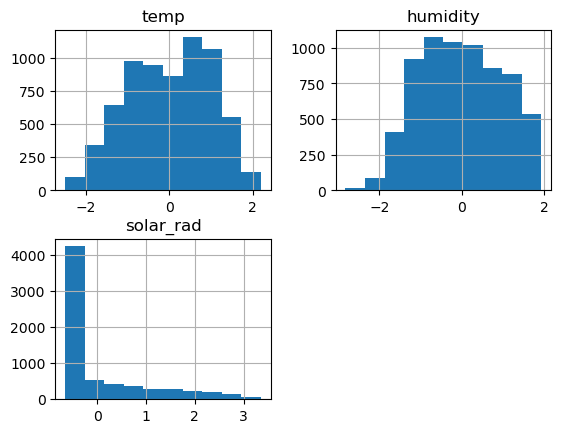

In [55]:
def normalize(feature):
    return (feature - feature.mean())/ feature.std()

cont = ['temp', 'humidity', 'solar_rad']

X_train_m2 = X_train[cont].apply(normalize)

X_train_m2.hist();

In [56]:
# creating dummy variables
hour_dummies = create_dummy('hour', X_train)
rain_dummies = create_dummy('rainfall_mm', X_train)
snow_dummies = create_dummy('snowfall_cm', X_train)
holiday_dummies = create_dummy('holiday', X_train)
month_dummies = create_dummy('month', X_train)
day_dummies = create_dummy('day_of_week', X_train)
daylight_dummies = create_dummy('daylight', X_train)

# concating dummy columns into dataset
X_train_m2 = pd.concat([X_train_m2, hour_dummies, rain_dummies, snow_dummies, holiday_dummies, month_dummies, 
                        day_dummies, daylight_dummies], axis=1)

# removing dropping one column for each categorical
X_train_m2.drop(['hour_5', 'rainfall_mm_0.0', 'snowfall_cm_0.0', 'holiday_1', 'month_1', 'day_of_week_weekday', 
                 'daylight_0'], axis=1, inplace=True)

X_train_m2.head()

,temp,humidity,solar_rad,hour_0,hour_1,hour_2,hour_3,hour_4,hour_6,hour_7,...,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_of_week_weekend,daylight_1
2241,-0.328755,1.886252,-0.434182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
7149,0.604411,-0.202033,-0.662616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5177,1.141188,-0.299162,0.502398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3368,0.150215,-0.202033,0.353916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1459,-1.195855,1.594863,-0.662616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


                            OLS Regression Results                            
Dep. Variable:             bike_count   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     420.6
Date:                Fri, 06 Oct 2023   Prob (F-statistic):               0.00
Time:                        21:38:58   Log-Likelihood:                -49013.
No. Observations:                6772   AIC:                         9.811e+04
Df Residuals:                    6729   BIC:                         9.841e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -40.6284    

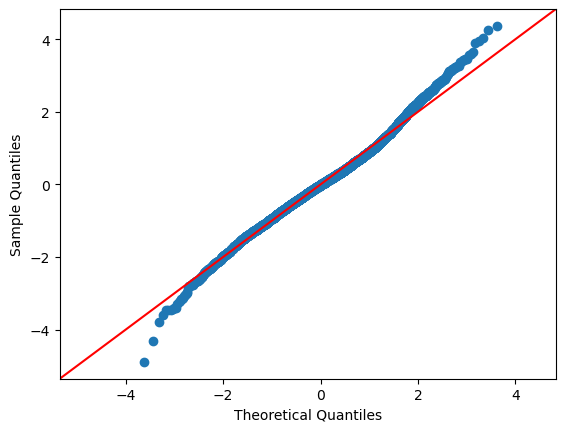

In [57]:
X = X_train_m2
y = y_train

# building the model
X_int = sm.add_constant(X)
model = sm.OLS(y, X_int).fit()
print(model.summary())

# checking normality assumptions
sm.qqplot(model.resid, line='45', fit=True);

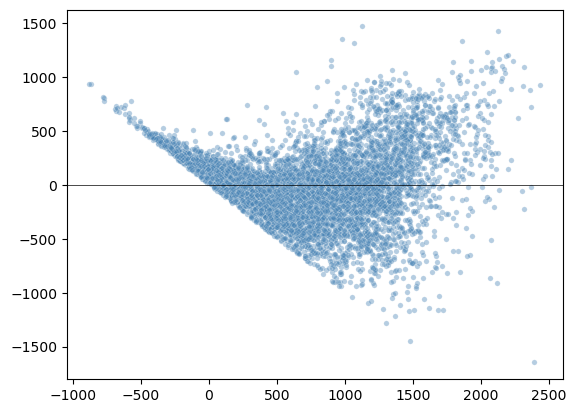

In [58]:
# checking homoscedasticity assumption
pred = model.predict(X_int)
residuals = model.resid

sns.scatterplot(x=pred, y=residuals, s=15, alpha=0.4, color='steelblue')
plt.axhline(y=0, color='black', linewidth=0.5);

In [59]:
name = ['F statistic', 'p-value']
test =  sm.stats.diagnostic.het_goldfeldquandt(model.resid, model.model.exog)
list(zip(name, test))

[('F statistic', 0.9483976265170475), ('p-value', 0.9371713955641667)]

In [60]:
name = ['Lagrange multiplier statistic', 'p-value', 
        'f-value', 'f p-value']
test = sm.stats.het_breuschpagan(model.resid, model.model.exog)
list(zip(name, test))

[('Lagrange multiplier statistic', 1948.0314012620834),
 ('p-value', 0.0),
 ('f-value', 64.6982775932369),
 ('f p-value', 0.0)]

In [61]:
linreg = LinearRegression()

crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
baseline = np.mean(cross_val_score(linreg, X, y, scoring="r2", cv=crossvalidation))

interactions = []

feat_combinations = combinations(X.columns, 2)

data = X.copy()
for i, (a, b) in enumerate(feat_combinations):
    data["interaction"] = data[a] * data[b]
    score = np.mean(
        cross_val_score(linreg, data, y, scoring="r2", cv=crossvalidation)
    )
    if score > baseline:
        interactions.append((a, b, round(score, 3)))

    if i % 50 == 0:
        print(i)

print(
    "Top 5 interactions: %s"
    % sorted(interactions, key=lambda inter: inter[2], reverse=True)[:5]
)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
Top 5 interactions: [('hour_8', 'day_of_week_weekend', 0.733), ('temp', 'hour_18', 0.731), ('temp', 'hour_19', 0.729), ('solar_rad', 'hour_19', 0.729), ('temp', 'hour_21', 0.728)]


In [62]:
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
final_m2 = X.copy()

final_m2['hour_8*day_of_week_weekend'] = (final_m2['hour_8'] * final_m2['day_of_week_weekend'])

final_model_2 = np.mean(cross_val_score(linreg, final_m2, y, scoring="r2", cv=crossvalidation))

print(f'Baseline r2: {baseline}')
print(f'Final Model r2: {final_model_2}')

Baseline r2: 0.7200367148326876
Final Model r2: 0.7333335614582353


In [63]:
linreg.fit(X, y)

LinearRegression()